In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from grayscott import GrayScott
from constants import *

# Gray-Scott Model Metrics

In [7]:
grayscott = GrayScott(F=0.04, k=0.06, D_u=D_u, D_v=D_v, x0=x0, x1=x1, N=N)
U, V = grayscott.forward(0,10000)

F=0.040, k=0.060: 100%|█████████████████████████████████████▉| 16380/16384 [00:21<00:00, 759.75it/s]


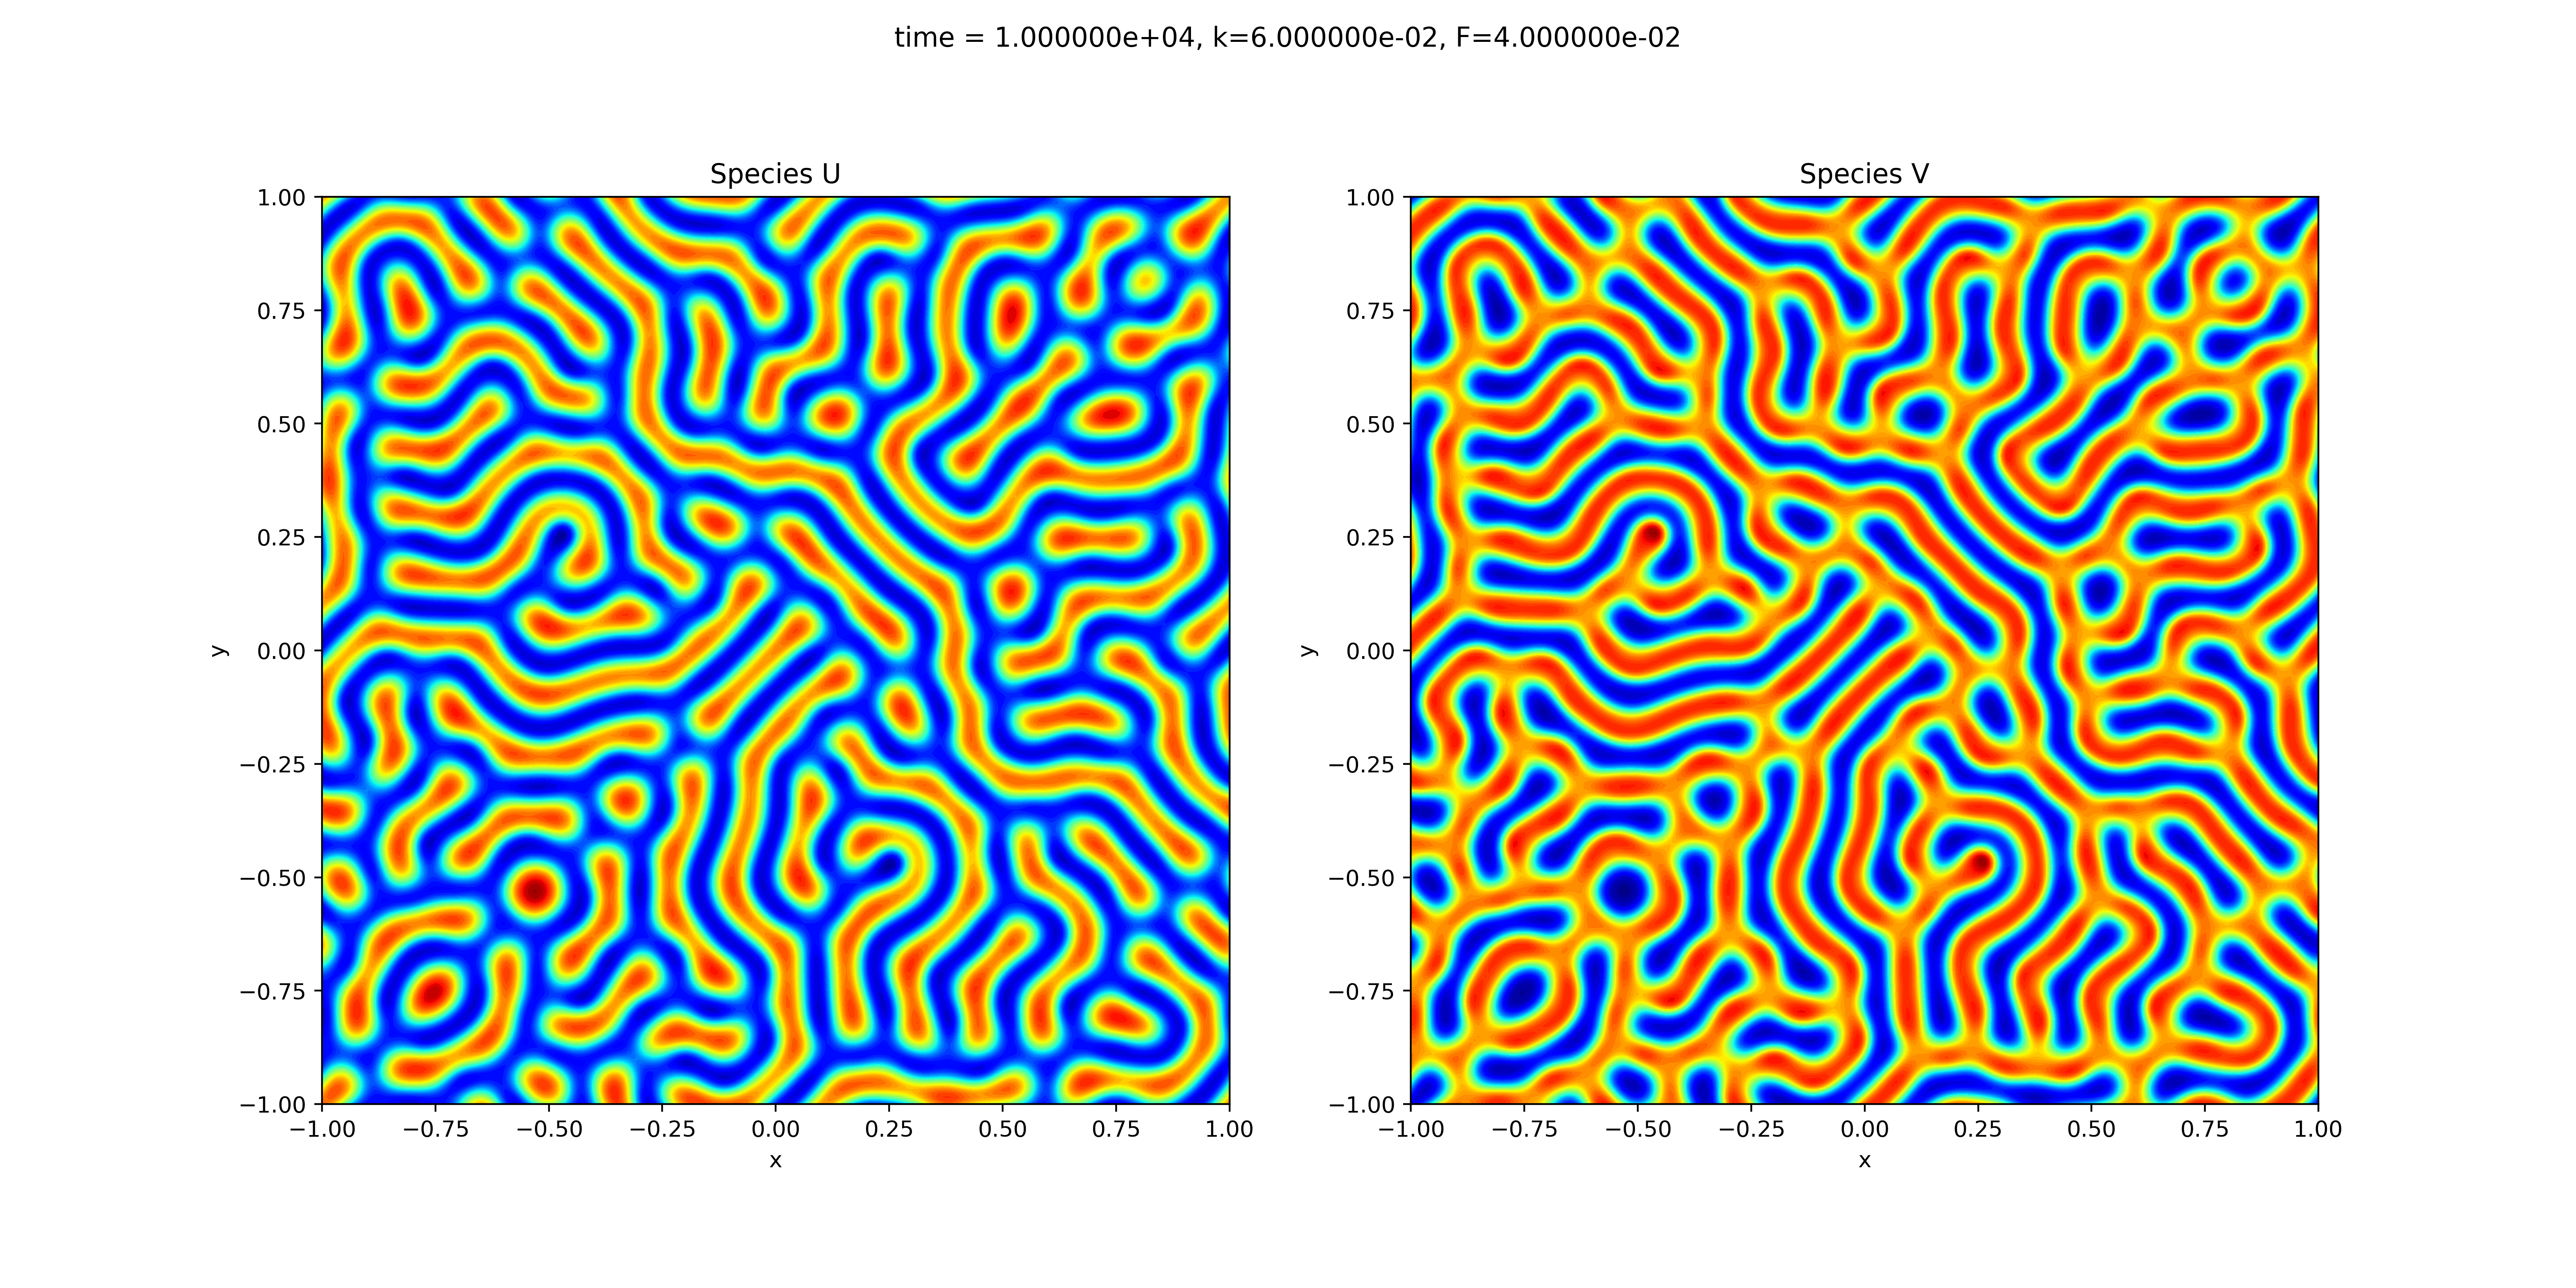

In [3]:
Image(filename='../frames/frame_t10000.000_k0.060_f0.040.png')

In [3]:
def spatial_power_spectrum(field):
    f = field[1:-1, 1:-1]

    F = np.fft.fftshift(np.fft.fft2(f))
    P = np.abs(F)**2

    ny, nx = f.shape
    cy, cx = ny//2, nx//2
    Y, X = np.ogrid[:ny, :nx]
    r = np.sqrt((X - cx)**2 + (Y - cy)**2)

    r = r.astype(int)
    radial_ps = np.bincount(r.ravel(), weights=P.ravel()) / np.bincount(r.ravel())
    return radial_ps

def dominant_wavelength(radial_ps, L):
    peak_index = np.argmax(radial_ps[1:]) + 1
    wavelength = L / peak_index
    return wavelength

In [ ]:
for k_test in k_values:
    for F_test in F_values:
        V = np.loadtxt(f"../data/V_t3000.000_k{k_test:.3f}_f{F_test:.3f}.csv", delimiter=",")
        radial_ps = spatial_power_spectrum(V)
        plt.plot(radial_ps)
        plt.yscale("log")
        plt.title(f"Radial Spatial Power Spectrum for k={k_test:.3f} and F={F_test:.3f}")
        plt.xlabel("Spatial frequency")
        plt.show()

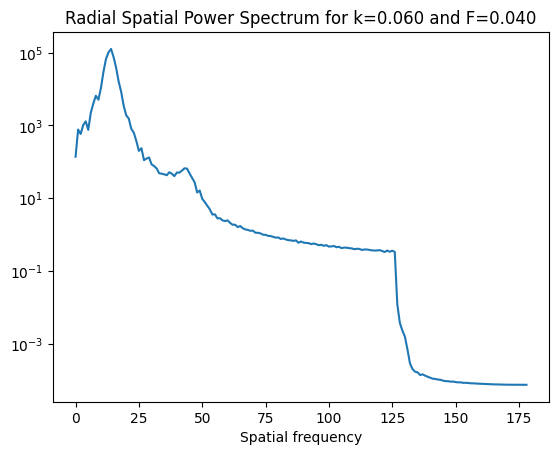

In [4]:
k_test = 0.06
F_test = 0.04
V = np.loadtxt(f"../data/V_t10000.000_k{k_test:.3f}_f{F_test:.3f}.csv", delimiter=",")
radial_ps = spatial_power_spectrum(V)[1:]
plt.plot(radial_ps)
plt.yscale("log")
plt.title(f"Radial Spatial Power Spectrum for k={k_test:.3f} and F={F_test:.3f}")
plt.xlabel("Spatial frequency")
plt.show()

In [5]:
dominant_wavelength(radial_ps, N+1)

np.float64(18.357142857142858)

In [9]:
def spatial_autocorrelation(field):
    f = field[1:-1,1:-1]
    f = f - np.mean(f)  # zero mean

    F = np.fft.fft2(f)
    S = np.abs(F)**2
    ac = np.fft.ifft2(S).real
    ac = np.fft.fftshift(ac)

    ac /= ac.max()  # normalize
    return ac

def correlation_length(ac, dx):
    cy, cx = ac.shape[0]//2, ac.shape[1]//2
    centerline = ac[cy, :]  # extract horizontal line
    # find first index where correlation < 1/e
    target = 1 / np.e
    idx = np.where(centerline < target)[0]
    if len(idx) == 0:
        return None
    dist = np.abs(idx[0] - cx) * dx
    return dist

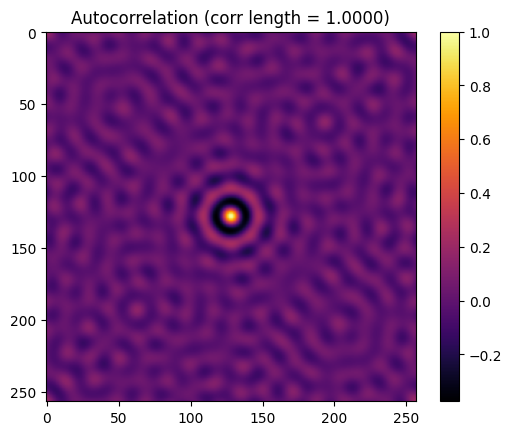

In [10]:
ac = spatial_autocorrelation(V)
corr_len = correlation_length(ac, grayscott.dx)

plt.imshow(ac, cmap='inferno')
plt.title(f"Autocorrelation (corr length = {corr_len:.4f})")
plt.colorbar()
plt.show()

In [11]:
def pattern_entropy(field, bins=50):
    """Compute Shannon entropy of a normalized 2D pattern."""
    f = field[1:-1,1:-1]  # remove ghost cells
    hist, _ = np.histogram(f, bins=bins, range=(f.min(), f.max()), density=True)
    p = hist / np.sum(hist)
    p = p[p > 0]
    entropy = -np.sum(p * np.log(p))
    return entropy

In [12]:
entropy = pattern_entropy(V)
print(f"Pattern entropy: {entropy:.3f}")

Pattern entropy: 3.704
